In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from multirotor.coords import direction_cosine_matrix, inertial_to_body, body_to_inertial
from multirotor.simulation import Multirotor

In [2]:
# inertia_matrix=np.asarray([
#     [0.2206, 0, 0],
#     [0, 0.2206, 0.],
#     [0, 0, 0.4238]
# ]).astype(np.float32)

In [3]:
inertia_matrix=np.asarray([
    [0.2506, 0, 0],
    [0, 0.2506, 0.],
    [0, 0, 0.4538]
]).astype(np.float32)

In [4]:
inertia_matrix_inverse=np.asarray([
    [3.9904, 0, 0],
    [0, 3.9904, 0.],
    [0, 0, 2.2036]
]).astype(np.float32)

In [5]:
inertia_matrix_inverse = np.linalg.inv(inertia_matrix).astype(np.float32)

In [6]:
def apply_forces_torques(
    forces: np.ndarray, torques: np.ndarray, x: np.ndarray, g: float, mass: float,
    inertia_matrix: np.matrix, inertia_matrix_inverse: np.matrix
) -> np.ndarray:
    """
    Given forces and torqes, return the rate of change of state.

    Parameters
    ----------
    forces : np.ndarray
        Forces acting in the body frame.
    torques : np.ndarray
        Torques acting in the body frame.
    x : np.ndarray
        State of the vehicle.
    g : float
        Gravitational acceleration.
    mass : float
        Mass of the vehicle.
    inertia_matrix : np.matrix
        Inertial matrix.
    inertia_matrix_inverse : np.matrix
        Inverse of inertial matrix.

    Returns
    -------
    np.ndarray
        The rate of change of state d(state)/dt
    """
    # Store state variables in a readable format
    xI = x[0]       # Inertial frame positions
    yI = x[1]
    zI = x[2]
    ub = x[3]       # linear velocity along body-frame-x-axis b1
    vb = x[4]       # linear velocity along body-frame-y-axis b2
    wb = x[5]       # linear velocity along body-frame-z-axis b3
    phi = x[6]      # Roll
    theta = x[7]    # Pitch
    psi = x[8]      # Yaw
    p = x[9]        # body-frame-x-axis rotation rate
    q = x[10]       # body-frame-y-axis rotation rate
    r = x[11]       # body-frame-z-axis rotation rate
    
    # Pre-calculate trig values
    cphi = np.cos(phi);   sphi = np.sin(phi)    # roll
    cthe = np.cos(theta); sthe = np.sin(theta)  # pitch
    cpsi = np.cos(psi);   spsi = np.sin(psi)    # yaw

    f1, f2, f3 = forces # in the body frame (b1, b2, b3)
    t1, t2, t3 = torques
    I = inertia_matrix
    I_inv = inertia_matrix_inverse
    
    # Calculate the derivative of the state matrix using EOM
    xdot = np.zeros_like(x)

    # velocity = dPosition (inertial) / dt (convert body velocity to inertial)
    # Essentially = Rotation matrix (body to inertial) x body velocity
    # dcm = direction_cosine_matrix(roll=phi, pitch=theta, yaw=psi)
    # xdot[0:3] = body_to_inertial(x[3:6], dcm)
    xdot[0] = cthe*cpsi*ub + (-cphi * spsi + sphi*sthe*cpsi) * vb + \
        (sphi*spsi+cphi*sthe*cpsi) * wb  # = xIdot 
    xdot[1] = cthe*spsi * ub + (cphi*cpsi+sphi*sthe*spsi) * vb + \
        (-sphi*cpsi+cphi*sthe*spsi) * wb # = yIdot 
    xdot[2] = (-sthe * ub + sphi*cthe * vb + cphi*cthe * wb) # = zIdot

    #  Acceleration = dVelocity (body frame) / dt
    #           External forces     Gravity             Coriolis effect
    xdot[3] = 1/mass * (f1)     + g * sthe          + r * vb - q * wb  # = udot
    xdot[4] = 1/mass * (f2)     - g * sphi * cthe   - r * ub + p * wb # = vdot
    xdot[5] = 1/mass * (f3)     - g * cphi * cthe   + q * ub - p * vb # = wdot

    # Orientation
    xdot[6] = p + (q*sphi + r*cphi) * sthe / cthe  # = phidot
    xdot[7] = q * cphi - r * sphi  # = thetadot
    xdot[8] = (q * sphi + r * cphi) / cthe  # = psidot

    # Angular rate
    gyro = np.cross(x[9:12], I @ x[9:12])
    xdot[9:12] = I_inv @ (torques - gyro)
    return xdot

In [7]:
def step(forces, moments, deltat, state, mass, mom):
    """Takes the inputted force and moment arrays and updates the current objects positions

    :param forces:
        An array of forces on the object (in Newtons)
    :type forces:
        numpy.ndarray or list
    :param moments:
        An array of moments on the object (in N m)
    :type moments:
        numpy.ndarray or list
    :param deltat:
        The timestamp to compute
    :type deltat:
        float
    :return:
        The updated pos, vel, rot, rot_rate
    :rtype:
        Tuple(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)
		"""
  
    pos = state[0:3]
    vel = state[3:6]
    rot = state[6:9]
    rot_rate = state[9:12]
    
    forces = np.array(forces)
    moments = np.array(moments)

    # vel = vel * deltat + np.divide(forces, mass) * deltat
    vel = vel + np.divide(forces, mass) * deltat
    
    pos += np.dot(vel, deltat)

    rot_rate = rot_rate + np.divide(moments, mom) * deltat
    rot += np.dot(rot_rate, deltat)

    new_state = np.concatenate([pos, vel, rot, rot_rate])

    return new_state

In [8]:
initial_state = np.zeros(12, dtype=np.float32)
initial_state[2] = 30

In [9]:
forces = pd.read_csv('./data/nominal_f.csv')
torques = pd.read_csv('./data/nominal_t.csv')
speeds = pd.read_csv('./data/speeds.csv')

In [10]:
speeds = speeds.to_numpy()

In [11]:
from scipy.signal import medfilt

In [12]:
f_array = forces.to_numpy().astype(np.float32)
f_array = f_array[:, :3]
t_array = torques.to_numpy().astype(np.float32)

In [13]:
# f_array = np.ones((10000, 3))
# f_array[:,2] *= 104.468
# f_array[:,0] *= 0
# f_array[:,1] *= 0


In [14]:
# t_array *= 0

In [15]:
# f_array = np.repeat(f_array, 2, axis=0)
# t_array = np.repeat(t_array, 2, axis=0)

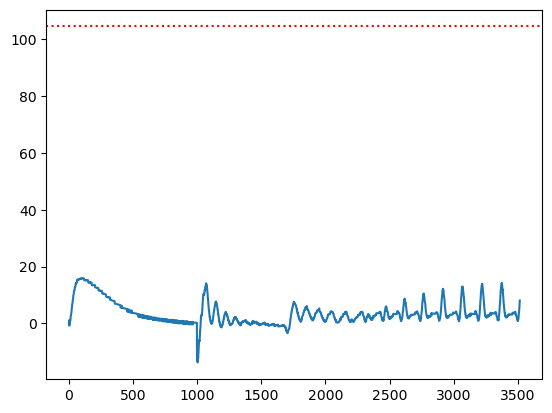

In [16]:
plt.plot(f_array[:,2])
plt.axhline(y=104.5746, linestyle=':', color='red')

In [17]:
filtered_f = medfilt(f_array)
filtered_t = medfilt(t_array)

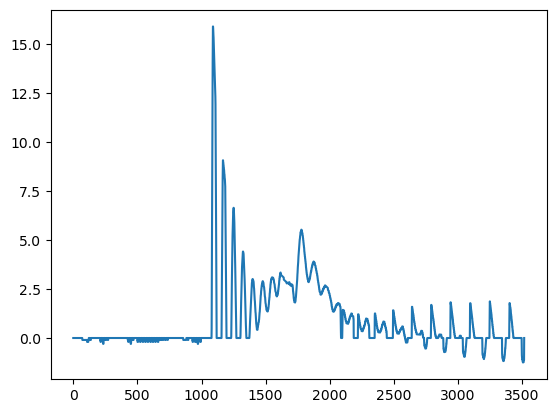

In [18]:
plt.plot(filtered_f[:,0])

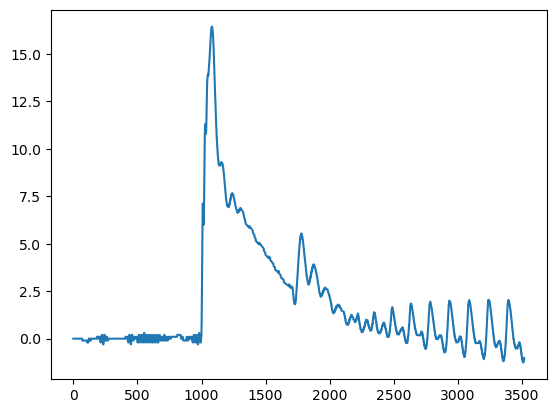

In [19]:
plt.plot(f_array[:,0])

In [20]:
def dxdt(prev_state, f, tor, _, t):
    new_dxdt = apply_forces_torques(f, tor, prev_state, 9.81, 10.66, inertia_matrix, inertia_matrix_inverse)
    # new_x = (prev_state + 0.5 * (old_dxdt + new_dxdt) * 0.01).astype(np.float32)
    return new_dxdt

In [21]:
from scipy.integrate import odeint

In [22]:
def runge_kutta_integrate(prev_state, dxdt, dt):
    k1 = dxdt
    k2 = dxdt + 0.5 * dt * k1
    k3 = dxdt + 0.5 * dt * k2
    k4 = dxdt + dt * k3

    new_state = prev_state + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return new_state.astype(np.float32)


In [23]:
# states = []
# prev_state = initial_state.copy()
# old_dxdt = initial_state.copy()
# # f_array = filtered_f
# # t_array = filtered_t

# method = "current"
# for f, t in zip(f_array, t_array):
#     dcm = direction_cosine_matrix(prev_state[6], prev_state[7], prev_state[8])
#     f[2] = body_to_inertial(f, dcm)[2]
#     if method == "current":
#         new_dxdt = apply_forces_torques(f, t, prev_state, 9.8, 10.66, inertia_matrix, inertia_matrix_inverse)
#         new_x = (prev_state + 0.5 * (old_dxdt + new_dxdt) * 0.01).astype(np.float32)
#     elif method == '6dof':
#         new_x = step(f, t, 0.01, prev_state, 10.66, np.diag(inertia_matrix))
#     elif method == "ode":
#         new_x = odeint(
#             dxdt, prev_state, (0, 0.01),
#             args=(f, t),
#             rtol=1e-4, atol=1e-4, tfirst=True
#         )[-1]
#     elif method == "rk":
#         new_dxdt = apply_forces_torques(f, t, prev_state, 9.8, 10.66, inertia_matrix, inertia_matrix_inverse)
#         new_x = runge_kutta_integrate(prev_state, new_dxdt, 0.01)
#     states.append(new_x)
    
#     old_dxdt = new_dxdt
#     prev_state = new_x
    
# states = np.array(states)

In [24]:
from multirotor.vehicle import BatteryParams, MotorParams, PropellerParams, VehicleParams, SimulationParams
from copy import deepcopy

In [25]:
BP = BatteryParams(max_voltage=22.2)
MP = MotorParams(
    moment_of_inertia=5e-5,
    resistance=0.27,
    # resistance=0.081,
    k_emf=0.0265,
    k_motor=0.0932,
    # speed_voltage_scaling=0.0347,
    max_current=38.
)
PP = PropellerParams(
    moment_of_inertia=1.86e-6,
    use_thrust_constant=True,
    k_thrust=9.8419e-05, # 18-inch propeller
    # k_thrust=5.28847e-05, # 15 inch propeller
    k_drag=1.8503e-06, # 18-inch propeller
    # k_drag=1.34545e-06, # 15-inch propeller
    motor=MP
    # motor=None
)
VP = VehicleParams(
    propellers=[deepcopy(PP) for _ in range(8)],
    battery=BP,
    # angles in 45 deg increments, rotated to align with
    # model setup in gazebo sim (not part of this repo)
    angles=np.linspace(0, -2*np.pi, num=8, endpoint=False) + 0.375 * np.pi, # np.pi / 2
    # angles=np.linspace(0, -2*np.pi, num=8, endpoint=False) + np.pi / 2, # np.pi / 2
    distances=np.ones(8) * 0.635,
    clockwise=[-1,1,-1,1,-1,1,-1,1],
    mass=10.66,
    # inertia_matrix=np.asarray([
    #     [0.2206, 0, 0],
    #     [0, 0.2206, 0.],
    #     [0, 0, 0.4238]
    # ])
    inertia_matrix=np.asarray([
        [0.2506, 0, 0],
        [0, 0.2506, 0.],
        [0, 0, 0.4538]
    ])
)
SP = SimulationParams(dt=0.01, g=9.8, dtype=np.float32)
m = Multirotor(VP, SP)

In [26]:
def drag(state):
    rho = 1.2
    cd = 1
    Axy, Axz, Ayz = 0.403, 0.403, 0.403
    const = -0.5 * rho * cd

    # Make sure this wind vector can change
    wind_vector = np.array([0, 0, 0], dtype=np.float32)
    # dcm = direction_cosine_matrix(state[0], state[1], state[2])
    # v_wb = inertial_to_body(wind_vector, dcm)
    
    dcm = direction_cosine_matrix(state[6], state[7], state[8])
    Vb = inertial_to_body(state[3:6], dcm)

    # Vb = state[3:6]
    v_a = Vb
    newtons = const * np.array([Ayz * v_a[0]*np.abs(v_a[0]), Axz * v_a[1]*np.abs(v_a[1]), Axy * v_a[2]*np.abs(v_a[2])]) 
    # self.wind_forces.append(newtons)
    # return np.zeros(3, np.float32)
    return newtons

In [27]:
states = []
prev_state = initial_state.copy()
old_dxdt = initial_state.copy()
# f_array = filtered_f
# t_array = filtered_t
computed_forces = []
dfs = []
before_drag = []

method = "current"
for s in speeds:
    dcm = direction_cosine_matrix(prev_state[6], prev_state[7], prev_state[8])
    if method == "current":
        f, t = m.get_forces_torques(s, prev_state)
        df = drag(prev_state)
        dfs.append(df)
        before_drag.append(f)
        
        dt = 0
        computed_forces.append(f)
        new_dxdt = apply_forces_torques(f, dt+t, prev_state, 9.8, 10.66, inertia_matrix, inertia_matrix_inverse)
        
        new_x = (prev_state + 0.5 * (old_dxdt + new_dxdt) * 0.01).astype(np.float32)
    states.append(new_x)
    
    old_dxdt = new_dxdt
    prev_state = new_x
    
states = np.array(states)

In [28]:
def dxdt_speeds(t, x, u):
    forces, torques = m.get_forces_torques(
            u, x)
    # print('dxdt-x', self.t // self.simulation.dt, x.dtype)
    dxdt = apply_forces_torques(
        forces, torques, x, 9.8,
        10.66, inertia_matrix, inertia_matrix_inverse)
    
    return dxdt

In [29]:
from scipy.integrate import RK23

In [30]:
states = []
prev_state = initial_state.copy()
old_dxdt = initial_state.copy()
# f_array = filtered_f
# t_array = filtered_t
computed_forces = []
dfs = []
before_drag = []

method = "current"
t = 0
for s in speeds:
    dcm = direction_cosine_matrix(prev_state[6], prev_state[7], prev_state[8])
    if method == "current":
        new_x = odeint(
            dxdt_speeds, prev_state, (t, t+0.01),
            args=((s,)),
            rtol=1e-4, atol=1e-4, tfirst=True
        )[-1]
        t += 0.01
    states.append(new_x)
    
    old_dxdt = new_dxdt
    prev_state = new_x
    
states = np.array(states)

In [31]:
computed_forces = np.array(computed_forces)
before_drag = np.array(before_drag)
dfs = np.array(dfs)

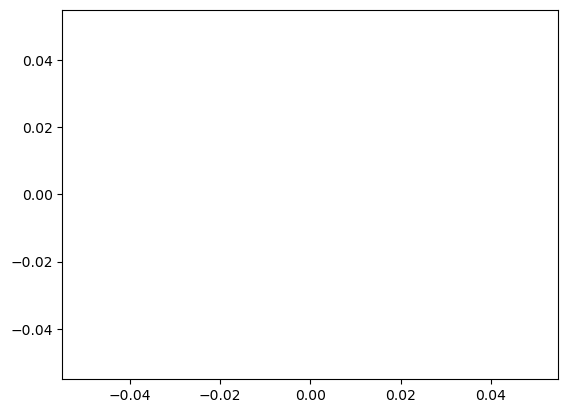

In [32]:
plt.plot(np.array(states)[:,0], np.array(states)[:,1])
# plt.xlim(-30, 30)
# plt.ylim(-250, 0)
# plt.plot(states[:,2])

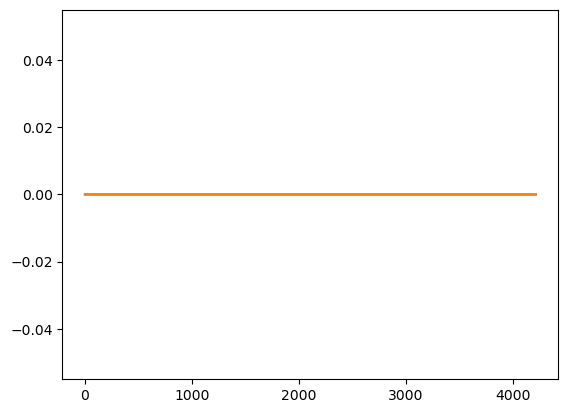

In [33]:
plt.plot(np.array(states)[:,0])
plt.plot(np.array(states)[:,1])

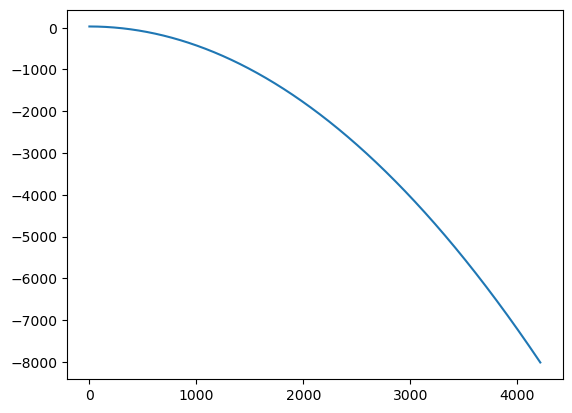

In [34]:
plt.plot(np.array(states)[:,2])

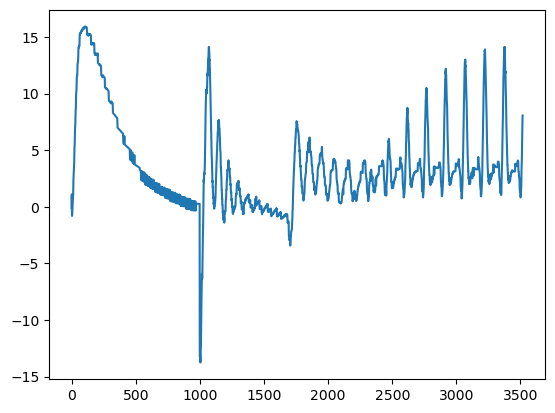

In [35]:
plt.plot(f_array[:,2])

In [36]:
len(states) / 100

42.16

In [37]:
np.count_nonzero(np.isnan(np.array(states)[:,0])) / 100

0.0

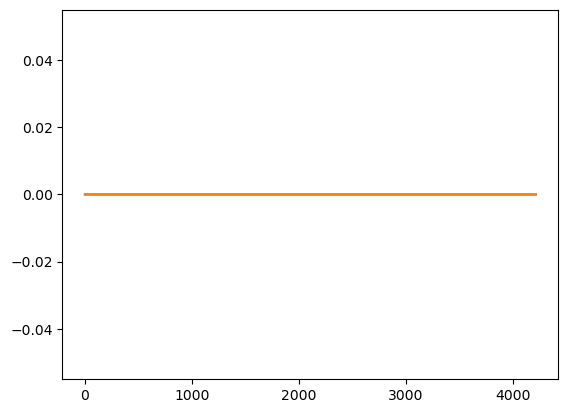

In [38]:
plt.plot(np.array(states)[:,0])
plt.plot(np.array(states)[:,1])

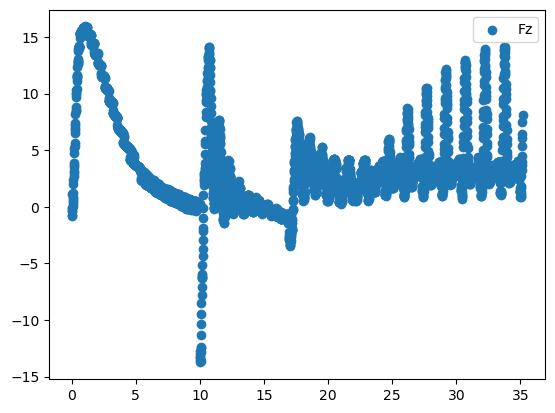

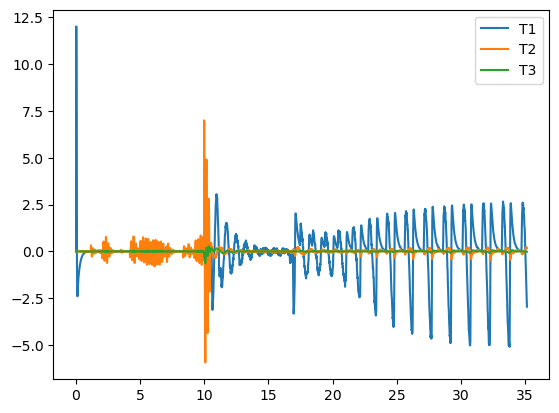

In [39]:
x = np.arange(len(f_array)) / 100
# plt.plot(x, f_array[:,0], label='Fx')
# plt.plot(x, f_array[:,1], label='Fy')
plt.scatter(x, f_array[:,2], label='Fz')
plt.legend()
plt.show()

plt.plot(x, t_array[:,0], label='T1')
plt.plot(x, t_array[:,1], label='T2')
plt.plot(x, t_array[:,2], label='T3')
plt.legend()
plt.show()

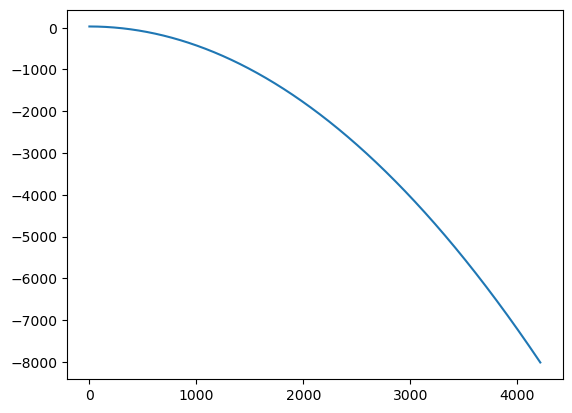

In [40]:
plt.plot(np.array(states)[:,2])